# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'notebooks-scripts','paper1','figs')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data
import random


In [5]:
import uncertainty.metrics as metrics

# Analysis

## Definitions

In [6]:
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = MODEL_ARC +'_' + DATA 

data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)
WEIGTH_FILE = 2

Files already downloaded and verified
Files already downloaded and verified


In [7]:
#names = ['natural',
#        'gaussian_blur',
#         'gaussian_noise']
LEVELS = (1,)
corrupted_dataloader = torch_data.CIFAR_C_loader(n = data.n_classes,data_dir = CORRUPTED_DATA_PATH,
                                                levels = LEVELS,natural_data = data.test_data)#,names = names)

## Upload Models

In [8]:
def weights_files(weights_path):
    #Get all weight files in weights_path
    files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
    files = sorted(files)
    return files

def upload_weights(file, weights_path):
    files = weights_files(weights_path)

    if isinstance(file,int):
        weights = files[file]
        weights = os.path.join(weights_path,weights)
    elif file == 'random':
        weights = random.choice(files)
        weights = os.path.join(weights_path,weights)
    elif file == 'max':
        return upload_weights(0, weights_path)
    elif isinstance(file,str):
        if file in files:
            weights = os.path.join(weights_path,file)
        elif file+'.pt' in files:
            weights = os.path.join(weights_path,file+'.pt')
        else: raise Exception("No file named ", file)
    state_dict = torch.load(weights)
    return state_dict


In [9]:
model = model_class(num_classes = data.n_classes, name = NAME,softmax = True).to(dev)
model.load_state_dict(upload_weights(WEIGTH_FILE ,weights_path))
model.eval()
acc_model = TE.model_acc(model,corrupted_dataloader)
rk_model = 1-0.01*acc_model
print(f'Acurácia = {acc_model}')

Acurácia = 62.693684210526314


## Plots

### Deterministic

In [10]:
name = NAME + '_Deterministic'
model.eval();

In [11]:
RC = metrics.selective_metrics(model,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05), name = name)

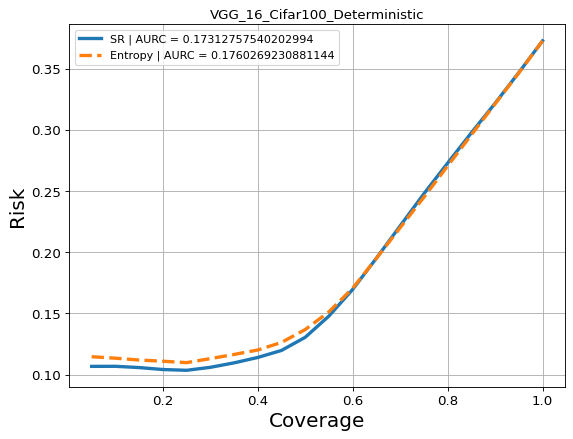

In [12]:
RC.plot_RC(aurc = True)
#plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### MonteCarlo Dropout

In [13]:
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout
N_SAMPLES = 10

#### MCD Ensemble

In [14]:
name = NAME + '_MCD_Ens'
model_mcd = MonteCarloDropout(model,return_uncs = False,n_samples = N_SAMPLES, as_ensemble = True,name = name).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcd,corrupted_dataloader,set_eval = False)}')

MCD Ensemble Total Accuracy: 64.25473684210526


In [15]:
RC = metrics.selective_metrics(model_mcd,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

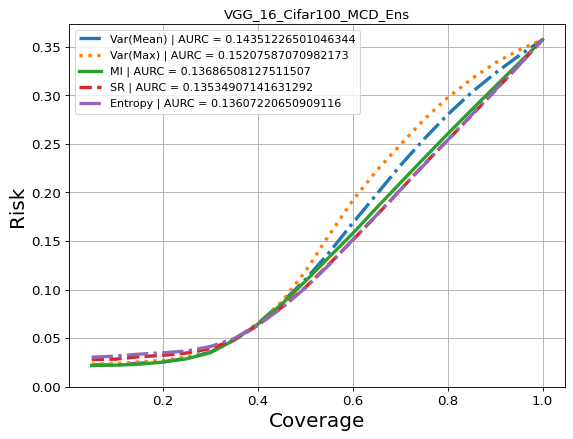

In [16]:
RC.plot_RC(aurc = True)
#plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

In [17]:
from collections import defaultdict
from matplotlib.pyplot import figure


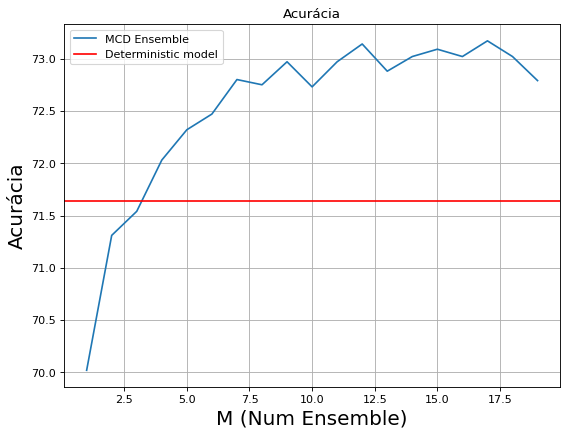

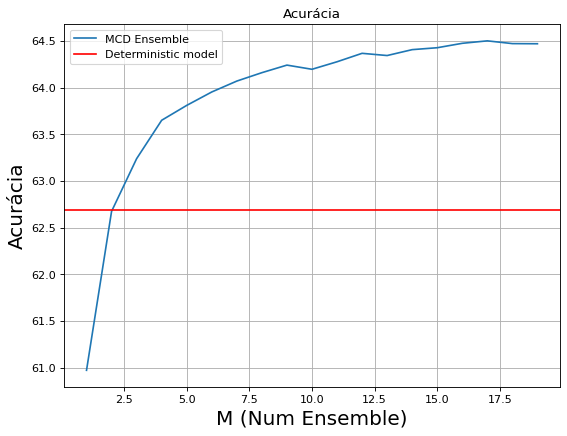

In [ ]:
acc_mcd = defaultdict(list)
acc_det = []
for level in range(1,6):
    LEVELS = tuple(range(level))
    corrupted_dataloader = torch_data.CIFAR_C_loader(n = data.n_classes,data_dir = CORRUPTED_DATA_PATH,
                                                    levels = LEVELS,natural_data = data.test_data)
    acc_det.append(TE.model_acc(model,corrupted_dataloader))
    for N_ENS in range(1,20):
        model_mcd = MonteCarloDropout(model,N_ENS, as_ensemble= True).to(dev)
        acc_mcd[level].append(TE.model_acc(model_mcd,corrupted_dataloader, set_eval = False))
    from matplotlib.pyplot import figure
    figure(figsize=RC.FIGSIZE, dpi=80)
    plt.plot(range(1,20),acc_mcd[level],label = 'MCD Ensemble')
    plt.axhline(acc_det[-1],label = 'Deterministic model',color='red')
    plt.xlabel("M (Num Ensemble)", fontsize=RC.LABEL_FONTSIZE)
    plt.ylabel("Acurácia", fontsize=RC.LABEL_FONTSIZE)
    plt.legend()
    plt.grid()
    plt.title('Acurácia')
    plt.show()

In [ ]:
acc_mcd = defaultdict(list)
acc_det = []
for level in range(2,6):
    LEVELS = tuple(range(level))
    corrupted_dataloader = torch_data.CIFAR_C_loader(n = data.n_classes,data_dir = CORRUPTED_DATA_PATH,
                                                    levels = LEVELS,natural_data = data.test_data)
    acc_det.append(TE.model_acc(model,corrupted_dataloader))
    for N_ENS in range(1,20):
        model_mcd = MonteCarloDropout(model,N_ENS, as_ensemble= True).to(dev)
        acc_mcd[level].append(TE.model_acc(model_mcd,corrupted_dataloader, set_eval = False))
    from matplotlib.pyplot import figure
    figure(figsize=RC.FIGSIZE, dpi=80)
    plt.plot(range(1,20),acc_mcd[level],label = 'MCD Ensemble')
    plt.axhline(acc_det[-1],label = 'Deterministic model',color='red')
    plt.xlabel("M (Num Ensemble)", fontsize=RC.LABEL_FONTSIZE)
    plt.ylabel("Acurácia", fontsize=RC.LABEL_FONTSIZE)
    plt.legend()
    plt.grid()
    plt.title('Acurácia')
    plt.show()

In [ ]:
N_SAMPLES = 10
model_mcd = MonteCarloDropout(model,return_uncs = False,n_samples = N_SAMPLES, as_ensemble = True,name = name).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcd,corrupted_dataloader,set_eval = False)}')

In [ ]:
for level in range(1,6):
    LEVELS = tuple(range(level))
    corrupted_dataloader = torch_data.CIFAR_C_loader(n = data.n_classes,data_dir = CORRUPTED_DATA_PATH,
                                                    levels = LEVELS,natural_data = data.test_data)
    RC = metrics.selective_metrics(model_mcd,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
    RC.RC_curves()
    
    #figure(figsize=RC.FIGSIZE, dpi=80)
    for name,val in RC.risk_diference().items():
        plt.plot(RC.c_list,val,label = name)
    plt.legend()
    plt.xlabel("Cobertura", fontsize=RC.LABEL_FONTSIZE)
    plt.ylabel("Diferença de Risco", fontsize=RC.LABEL_FONTSIZE)
    plt.grid()
    plt.show()